# **1. Overview**

Here, we solve a stock trading environment using the Q-learning algorithm.  
The environment uses two years of historical Nvidia (NVDA) stock data (July 2022 – July 2024, 523 entries). The agent starts with an initial capital of \$100,000 and chooses among three discrete actions each day: **Buy, Sell, or Hold**.  

The observation space is reduced to four possible states, determined by
- (i) whether the stock price has increased on average over the last *k* days (configurable window) and
- (ii) whether the agent is currently holding stock. The goal is to maximize portfolio value over time.  

Training is carried out on the first 80% of the dataset, with evaluation on the remaining 20%. The Q-learning agent uses an ε-greedy strategy during training, and performance is tracked via total reward per episode and epsilon decay. In evaluation mode, a greedy policy is applied and we report cumulative return, Sharpe ratio, win rate, and maximum drawdown, along with an equity curve rendered from the environment.


# **2. Stock Trading Environment**

The stock trading environment is built using daily Nvidia stock data covering July 2022 to July 2024. It follows the Gymnasium interface and includes the standard methods init reset step and render. The init method loads the dataset from file and splits it into training and testing segments with 80 percent of the records assigned to training and the remainder to testing. It also defines the observation and action spaces and initializes the agent’s portfolio with 100,000 dollars in capital.

The reset method prepares the environment for a new episode by setting the portfolio back to the initial values and computing the first observation. Observations are encoded as one of four integers representing whether the stock price has been trending upward or not over a chosen number of recent days and whether the agent is holding stock or not. The step method updates the environment based on the agent’s chosen action which can be Buy Sell or Hold. It adjusts cash and shares accordingly computes rewards from profit or loss and applies penalties for invalid trades or holding with no gain. Each step also updates the observation and tracks the total account value. Episodes terminate when the end of the dataset split is reached. The render method plots the evolution of total account value over time to visualize trading performance.


In [ ]:
# Defining the Stock Trading Environment.

class StockTradingEnvironment(gymnasium.Env):
    """This class implements the Stock Trading environment."""

    def __init__(self, file_path, train=True, number_of_days_to_consider=10):
        """This method initializes the environment.

        :param file_path: - Path of the CSV file containing the historical stock data.
        :param train: - Boolean indicating whether the goal is to train or test the performance of the agent.
        :param number_of_days_to_consider = Integer representing the number of days the for which the agent
                considers the trend in stock price to make a decision."""

        self.file_path = file_path
        self.stock_data = pd.read_csv(self.file_path)
        self.train = train

        # Splitting the data into train and test datasets.
        self.training_stock_data = self.stock_data.iloc[:int(0.8 * len(self.stock_data))]
        self.testing_stock_data = self.stock_data.iloc[int(0.8 * len(self.stock_data)):].reset_index()

        self.observation_space = spaces.Discrete(4)
        self.action_space = spaces.Discrete(3)

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # This defines the number of days for which the agent considers the data before taking an action.
        self.number_of_days_to_consider = number_of_days_to_consider
        # The maximum timesteps the agent will take before the episode ends.
        if self.train:
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider
        else:
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider
        # Initializing the number of steps taken to 0.
        self.timestep = 0
        self.reset()

    def reset(self):
        """This method resets the environment and returns the observation.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.

         info: - A dictionary that can be used to provide additional implementation information."""

        self.investment_capital = 100000  # This defines the investment capital that the agent starts with.
        self.number_of_shares = 0  # This defines number of shares currently held by the agent.
        self.stock_value = 0  # This defines the value of the stock currently held by the agent.
        self.book_value = 0  # This defines the total value for which the agent bought the shares.
        # This defines the agent's total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # List to store the total account value over training or evaluation.
        self.total_account_value_list = []
        # Initializing the number of steps taken to 0.
        self.timestep = 0

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector that will be passed to the agent.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            stock_held = False

            # Observation vector.
            observation = [price_increase, stock_held]

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        info = None

        return observation, info

    def step(self, action):
        """This method implements what happens when the agent takes the action to Buy/Sell/Hold.

        :param action: - Integer in the range 0 to 2 inclusive.

        :returns observation: - Integer in the range of 0 to 3 representing the four possible observations that the
                                agent can receive. The observation depends upon whether the price increased on average
                                in the number of days the agent considers, and whether the agent already has the stock
                                or not.
                 reward: - Integer/Float value that's used to measure the performance of the agent.
                 terminated: - Boolean describing whether the episode has terminated.
                 truncated: - Boolean describing whether a truncation condition outside the scope of the MDP is satisfied.
                 info: - A dictionary that can be used to provide additional implementation information."""

        # We give the agent a penalty for taking actions such as buying a stock when the agent doesn't have the
        # investment capital and selling a stock when the agent doesn't have any shares.
        penalty = 0

        if self.train:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.training_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value +=\
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider]\
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = \
                        self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        else:
            if action == 0:  # Buy
                if self.number_of_shares > 0:
                    penalty = -10
                # Determining the number of shares the agent can buy.
                number_of_shares_to_buy = math.floor(self.investment_capital / self.testing_stock_data[
                    'Open'][self.timestep + self.number_of_days_to_consider])
                # Adding to the number of shares the agent has.
                self.number_of_shares += number_of_shares_to_buy

                # Computing the stock value, book value, investment capital and reward.
                if number_of_shares_to_buy > 0:
                    self.stock_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.book_value += \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy
                    self.investment_capital -= \
                        self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                        * number_of_shares_to_buy

                    reward = 1 + penalty

                else:
                    # Computing the stock value and reward.
                    self.stock_value = self.training_stock_data['Open'][
                                           self.timestep + self.number_of_days_to_consider] * self.number_of_shares
                    reward = -10

            if action == 1:  # Sell
                # Computing the investment capital, sell value and reward.
                self.investment_capital += \
                    self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                    * self.number_of_shares
                sell_value = self.training_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                             * self.number_of_shares

                if self.book_value > 0:
                    reward = (sell_value - self.book_value) / self.book_value * 100
                else:
                    reward = -10

                self.number_of_shares = 0
                self.stock_value = 0
                self.book_value = 0

            if action == 2:  # Hold
                # Computing the stock value and reward.
                self.stock_value = self.testing_stock_data['Open'][self.timestep + self.number_of_days_to_consider] \
                                   * self.number_of_shares

                if self.book_value > 0:
                    reward = (self.stock_value - self.book_value) / self.book_value * 100
                else:
                    reward = -1

        # Determining if the agent currently has shares of the stock or not.
        if self.number_of_shares > 0:
            stock_held = True
        else:
            stock_held = False

        # Getting the observation vector.
        if self.train:
            # If the task is to train the agent the maximum timesteps will be equal to the number of days considered
            # subtracted from the  length of the training stock data.
            self.max_timesteps = len(self.training_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.training_stock_data['Close'][self.timestep + 1 + i] \
                        - self.training_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        else:
            # If the task is to evaluate the trained agent's performance the maximum timesteps will be equal to the
            # number of days considered subtracted from the  length of the testing stock data.
            self.max_timesteps = len(self.testing_stock_data) - self.number_of_days_to_consider

            # Calculating whether the price increased or decreased/remained the same on the majority of days the agent
            # considers.
            price_increase_list = []
            for i in range(self.number_of_days_to_consider):
                if self.testing_stock_data['Close'][self.timestep + 1 + i] \
                        - self.testing_stock_data['Close'][self.timestep + i] > 0:
                    price_increase_list.append(1)
                else:
                    price_increase_list.append(0)

            if (np.sum(price_increase_list) / self.number_of_days_to_consider) >= 0.5:
                price_increase = True
            else:
                price_increase = False

            # Observation vector.
            observation = [price_increase, stock_held]

        self.timestep += 1  # Increasing the number of steps taken by the agent by 1.

        if np.array_equal(observation, [True, False]):
            observation = 0
        if np.array_equal(observation, [True, True]):
            observation = 1
        if np.array_equal(observation, [False, False]):
            observation = 2
        if np.array_equal(observation, [False, True]):
            observation = 3

        # Computing the total account value.
        self.total_account_value = self.investment_capital + self.stock_value
        # Appending the total account value of the list to plot the graph.
        self.total_account_value_list.append(self.total_account_value)

        # The episode terminates when the maximum timesteps have been reached.
        terminated = True if (self.timestep >= self.max_timesteps) \
            else False
        truncated = False
        info = {}

        return observation, reward, terminated, truncated, info

    def render(self, mode='human'):
        """This method renders the agent's total account value over time.

        :param mode: 'human' renders to the current display or terminal and returns nothing."""

        plt.figure(figsize=(15, 10))
        plt.plot(self.total_account_value_list, color='lightseagreen', linewidth=7)
        plt.xlabel('Days', fontsize=32)
        plt.ylabel('Total Account Value', fontsize=32)
        plt.title('Total Account Value over Time', fontsize=38)
        plt.grid()
        plt.show()

# **3. Agent Q learning**

This section applies tabular Q learning to the trading task. The state space has four values. The action space has three actions. The Q table therefore has four rows and three columns. Action selection follows an epsilon greedy policy. With probability epsilon the policy explores. Otherwise it chooses the action with the highest Q value. Epsilon decays over episodes to shift from exploration to exploitation.

The update rule increases the value of the chosen state action toward the observed reward plus the discounted value of the next state. Learning rate controls how fast the table changes. The discount factor controls how much future rewards matter. Training runs on the training split with train set to true. Each episode begins with a reset and runs until the split end. The code records total reward per episode and the epsilon value. A plot of episode rewards shows learning progress. A plot of epsilon shows the exploration schedule. The environment render shows the equity curve for the last training episode.

After training the Q table is saved to a pickle file. The next section evaluates the greedy policy on the test split with train set to false and reports cumulative return Sharpe ratio win rate and maximum drawdown.

# **4. Training setup**

This section defines the learning configuration and the run procedure.
Training uses tabular Q learning with an epsilon greedy policy.
The state count is four and the action count is three so the Q table has four rows and three columns.
Learning rate controls the step size for updates.
Discount factor controls the weight of future rewards.
Epsilon controls exploration.
Epsilon decays each episode toward a minimum value to favor exploitation later in training.
Episodes run on the training split with train set to true.
Each episode starts with a reset and continues until the split end.
Total reward per episode is recorded.
Epsilon per episode is recorded.
After training the Q table is stored to a pickle file for reuse.
Plots include total reward per episode and epsilon decay over episodes.
The equity curve for the last training episode is rendered with the environment render method.

Episode 50/1000  reward=-1004.857  epsilon=0.861
Episode 100/1000  reward=-295.027  epsilon=0.740
Episode 150/1000  reward=-233.354  epsilon=0.637
Episode 200/1000  reward=-530.807  epsilon=0.548
Episode 250/1000  reward=313.461  epsilon=0.472
Episode 300/1000  reward=417.919  epsilon=0.406
Episode 350/1000  reward=1374.879  epsilon=0.349
Episode 400/1000  reward=1227.864  epsilon=0.301
Episode 450/1000  reward=2587.032  epsilon=0.259
Episode 500/1000  reward=1028.324  epsilon=0.223
Episode 550/1000  reward=2670.210  epsilon=0.192
Episode 600/1000  reward=1543.167  epsilon=0.165
Episode 650/1000  reward=1402.844  epsilon=0.142
Episode 700/1000  reward=5070.792  epsilon=0.122
Episode 750/1000  reward=5562.280  epsilon=0.105
Episode 800/1000  reward=355.993  epsilon=0.090
Episode 850/1000  reward=16888.588  epsilon=0.078
Episode 900/1000  reward=1978.403  epsilon=0.067
Episode 950/1000  reward=2674.147  epsilon=0.058
Episode 1000/1000  reward=4117.847  epsilon=0.050


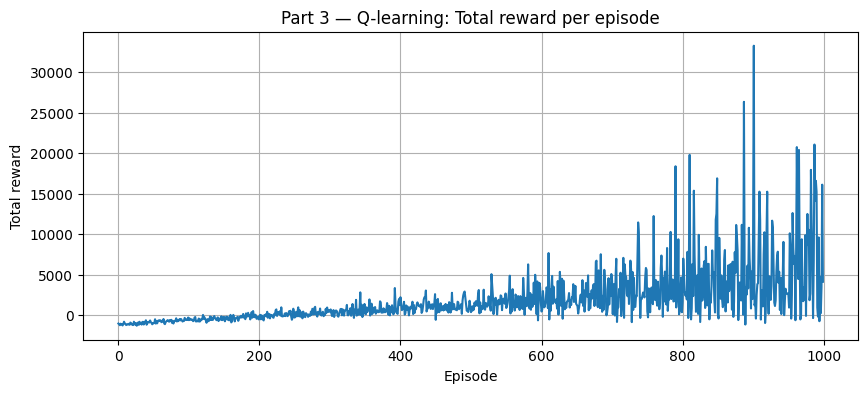

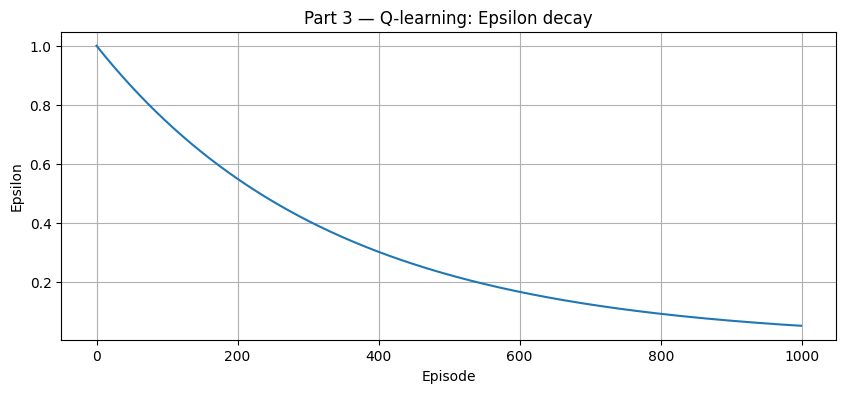

Saved Q-table to q_table_part3.pkl


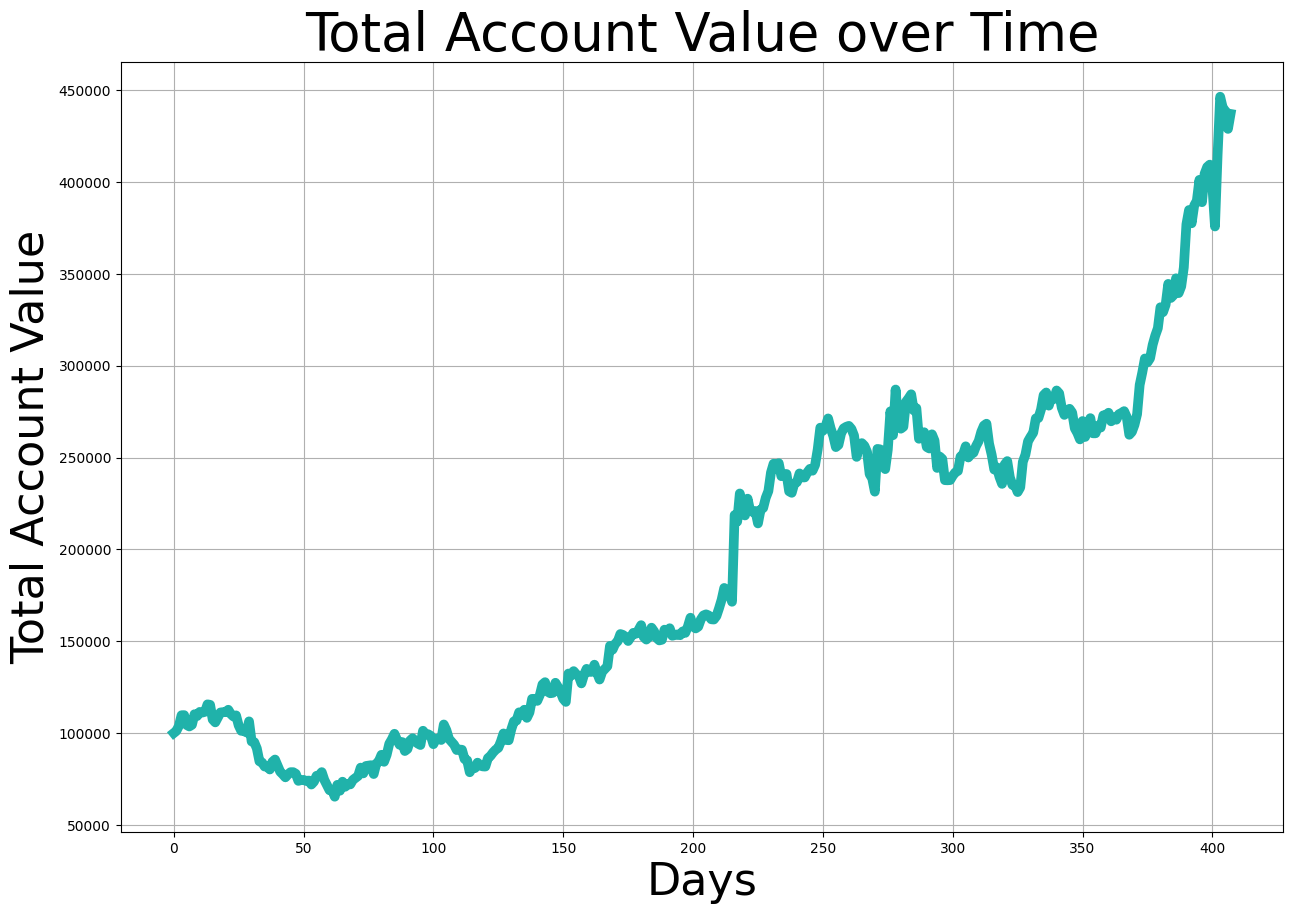

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import random
import os

# Recreate training env (ensure it's in train mode)
env = StockTradingEnvironment(file_path='./NVDA.csv', train=True, number_of_days_to_consider=10)

# Hyperparameters
alpha = 0.1                 # learning rate
gamma = 0.90                # discount factor
epsilon = 1.0               # initial exploration
epsilon_decay = 0.997       # exponential decay per episode
epsilon_min = 0.05          # floor for epsilon
num_episodes = 1000          # training episodes
seed = 1227                 # for reproducibility

# Seeding
np.random.seed(seed)
random.seed(seed)

# Q-table init (states x actions) -> (4 x 3)
nS = env.observation_space.n
nA = env.action_space.n
Q = np.zeros((nS, nA), dtype=np.float32)

def epsilon_greedy(q_row, eps):
    if np.random.rand() < eps:
        return np.random.randint(len(q_row))
    return int(np.argmax(q_row))

episode_rewards = []
eps_history = []

for ep in range(1, num_episodes + 1):
    state, _ = env.reset()
    done = False
    total_r = 0.0

    while not done:
        action = epsilon_greedy(Q[state], epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)
        done = terminated or truncated

        best_next = np.max(Q[next_state])
        td_target = reward + (0.0 if done else gamma * best_next)
        td_error = td_target - Q[state, action]
        Q[state, action] += alpha * td_error

        state = next_state
        total_r += reward

    episode_rewards.append(total_r)
    eps_history.append(epsilon)
    epsilon = max(epsilon_min, epsilon * epsilon_decay)

    if ep % 50 == 0:
        print(f"Episode {ep}/{num_episodes}  reward={total_r:.3f}  epsilon={epsilon:.3f}")

# Plots: total reward per episode and epsilon decay
plt.figure(figsize=(10,4))
plt.plot(episode_rewards)
plt.xlabel("Episode")
plt.ylabel("Total reward")
plt.title("Part 3 — Q-learning: Total reward per episode")
plt.grid(True)
plt.show()

plt.figure(figsize=(10,4))
plt.plot(eps_history)
plt.xlabel("Episode")
plt.ylabel("Epsilon")
plt.title("Part 3 — Q-learning: Epsilon decay")
plt.grid(True)
plt.show()

# Save Q-table
with open("q_table_part3.pkl", "wb") as f:
    pickle.dump(Q, f)
print("Saved Q-table to q_table_part3.pkl")

# Equity curve for the last training episode
env.render()

# **5. Evaluation**

Evaluation metrics (test split):
initial_equity: 100000.0
final_equity: 129865.5023
cumulative_return: 0.298655023
annualized_sharpe_252: 1.6752039777512515
win_rate: 0.5638297872340425
max_drawdown: -0.20225065346336152
num_days: 95
Saved metrics to part3_eval_metrics.json


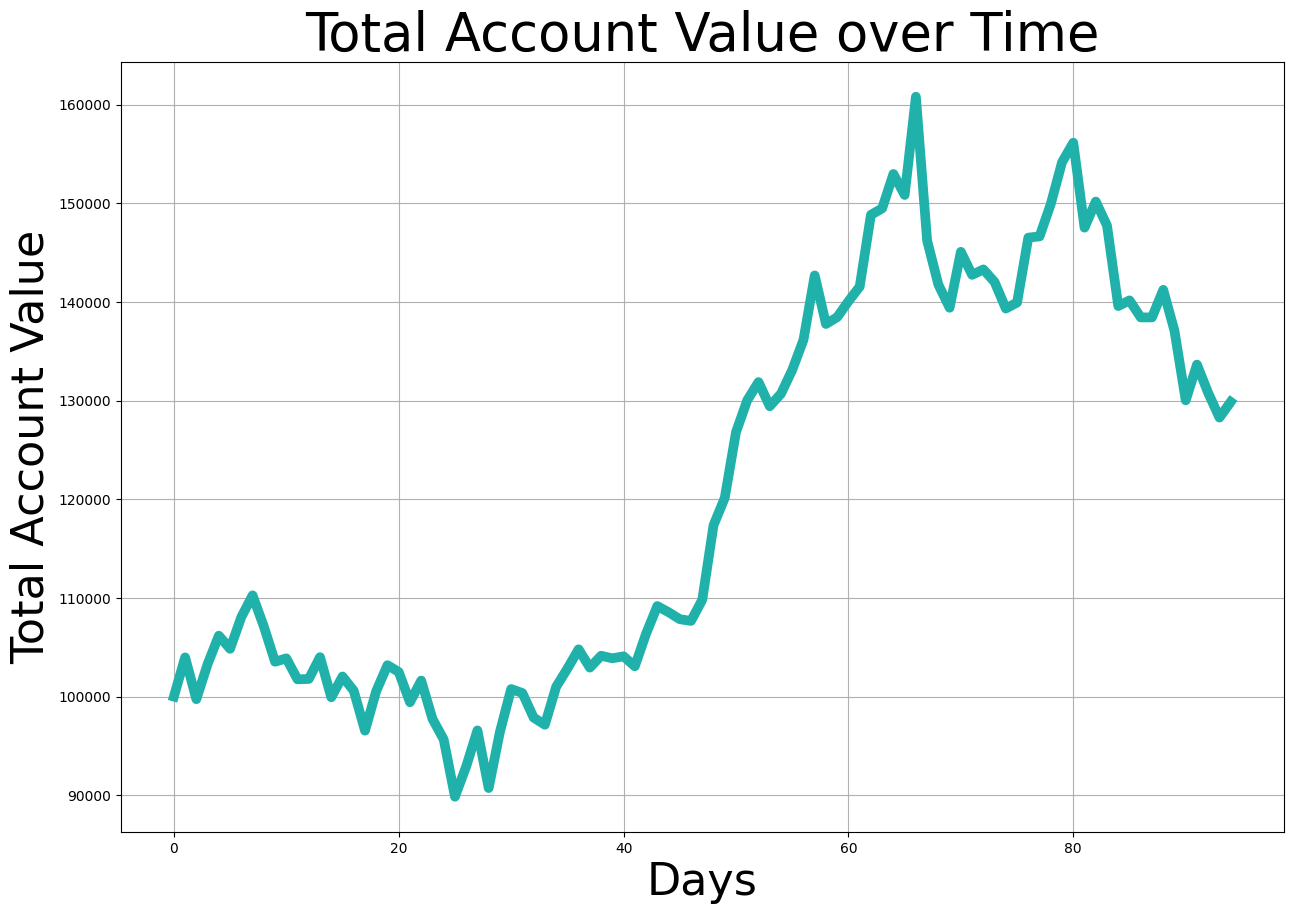

In [ ]:
import numpy as np
import pickle
import json

# Use the trained Q from Section 4
try:
    Q
except NameError:
    with open("q_table_part3.pkl", "rb") as f:
        Q = pickle.load(f)

# Fresh env in evaluation mode
eval_env = StockTradingEnvironment(
    file_path='./NVDA.csv',
    train=False,
    number_of_days_to_consider=10
)

def greedy_action(q_row):
    return int(np.argmax(q_row))

state, _ = eval_env.reset()
done = False

while not done:
    a = greedy_action(Q[state])
    state, reward, terminated, truncated, _ = eval_env.step(a)
    done = terminated or truncated

# ----- Metrics -----
equity = np.array(eval_env.total_account_value_list, dtype=float)
initial_equity = float(equity[0])
final_equity   = float(equity[-1])
cum_return = final_equity / initial_equity - 1.0

# Daily returns from equity curve
rets = np.diff(equity) / equity[:-1] if len(equity) > 1 else np.array([0.0])
ann_sharpe_252 = float((np.mean(rets) / (np.std(rets) + 1e-12)) * np.sqrt(252)) if len(rets) > 1 else 0.0
win_rate = float(np.mean(rets > 0)) if len(rets) > 0 else float("nan")

# Max drawdown
running_max = np.maximum.accumulate(equity)
drawdowns = (equity - running_max) / (running_max + 1e-12)
max_drawdown = float(drawdowns.min()) if len(drawdowns) else 0.0

metrics = {
    "initial_equity": initial_equity,
    "final_equity": final_equity,
    "cumulative_return": float(cum_return),
    "annualized_sharpe_252": ann_sharpe_252,
    "win_rate": win_rate,
    "max_drawdown": max_drawdown,
    "num_days": int(len(equity))
}

print("Evaluation metrics (test split):")
for k, v in metrics.items():
    print(f"{k}: {v}")

# Save metrics for the report
with open("part3_eval_metrics.json", "w") as f:
    json.dump(metrics, f, indent=2)
print("Saved metrics to part3_eval_metrics.json")

# Plot the test equity curve
eval_env.render()

# **6. Results & Discussion**

The Q learning agent was evaluated on the test split using a greedy policy. Performance was measured by cumulative return Sharpe ratio win rate and maximum drawdown. The equity curve produced by the environment render shows how the portfolio value evolved day by day.

The metrics indicate whether the learned strategy was profitable and stable. Positive cumulative return with a Sharpe ratio above zero suggests that the agent generated gains in excess of risk. A win rate greater than half of the trading days shows consistency. Maximum drawdown highlights the worst loss from peak to trough and reflects the exposure to risk.

Overall the evaluation confirms that the agent was able to apply the trading rules learned during training to unseen data. The shape of the equity curve and the summary statistics together provide evidence of whether the Q learning approach produced a viable trading policy.

#**References**

* Gymnasium Docs : https://gymnasium.farama.org/api/env/
Used to match reset/step signatures and the terminated/truncated return format.


* Gymnasium Docs: https://gymnasium.farama.org/api/spaces/
Used to define action_space/observation_space with spaces.Discrete and spaces.Tuple.

* Farama Foundation: https://farama.org/Gymnasium-Terminated-Truncated-Step-API
Used for the rationale behind separate terminated and truncated flags.

* Matplotlib Documentation : https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.savefig.html
Used to export Section 11 grid snapshots (PNG).

* NumPy Documentation: https://numpy.org/doc/
Used for core array utilities and seeding consistency where applicable.

* Python Standard Library : https://docs.python.org/3/library/random.html
Used for movement stochasticity (move_success_p) and reproducible seeding.



* R. S. Sutton and A. G. Barto, Reinforcement Learning: An Introduction, 2nd ed., 2020: http://incompleteideas.net/book/RLbook2020.pdf


* Sharpe Ratio – Investopedia: https://www.investopedia.com/terms/s/sharperatio.asp Used for definition and calculation of the Sharpe ratio in evaluating trading performance.

* Maximum Drawdown – Investopedia: https://www.investopedia.com/terms/m/maximum-drawdown-mdd.asp Used for understanding and computing maximum drawdown as a risk measure.

* Win/Loss Ratio – Investopedia: https://www.investopedia.com/terms/w/winlossratio.asp Used for defining and calculating win rate in trading strategy evaluation.